# Data Anlysis

## Importing librairies

In [58]:
import pickle
import os 
import json
import string
import requests
from IPython.display import clear_output

In [2]:
!pip install langdetect
!pip install names-dataset
!pip install bertopic
!pip install Wikidata
!pip install wordcloud
!pip install pyLDAvis
!pip install NRCLex
clear_output()

In [60]:
#EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from wikidata.client import Client
from tqdm import tqdm
from collections import Counter

#Preprocessing
from langdetect import detect
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from names_dataset import NameDataset
from itertools import chain 
import seaborn as sns

#Stats
import scipy.stats as stats

#LDA
from gensim.models import Phrases
from gensim import corpora
from gensim import models

#WordCloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Topic visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#BERTopic
#from bertopic import BERTopic

#Sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [61]:
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()
clear_output()

In [62]:
from nltk import download
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')
download('stopwords')
clear_output()

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 \
[[3]](https://www.nltk.org/) NLKT documentation 

# Table of contents
### [1. Extracted Topics](#1)

&nbsp;&nbsp;&nbsp;**[1.1 The topics](#1.1)**

&nbsp;&nbsp;&nbsp;**[1.2 Topics over time](#1.2)**

### [2. Targeted Topics ](#2)

&nbsp;&nbsp;&nbsp;**[2.1 The categories](#2.1)**


&nbsp;&nbsp;&nbsp;**[2.2 Categories over time](#2.2)**



### [3. Sentiments](#3)

&nbsp;&nbsp;&nbsp;**[3.1 The sentiments](#3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Plot sentiment analysis](#3.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Plot multi-sentiments](#3.1.2)

&nbsp;&nbsp;&nbsp;**[3.2 Sentiments over time](#3.2)**


### [4. Combined](#4)

&nbsp;&nbsp;&nbsp;**[4.1 Topics and sentiments](#4.1)**


&nbsp;&nbsp;&nbsp;**[4.2 Categories and sentiments](#4.2)**



## Context

All the preprocessing and data preparation have been done in `blabla.ipynb`. In this notebook, we will focus on the analysis of the information we obtained.

In [63]:
#Loadinf our complete dataset
movies = pd.read_pickle('data/movies_aug_bert+SA.pkl')

# 1. Extracted Topics <a id='1'></a>

## 1.1 The topics <a id='1.1'></a>

Idea for visualization:  
-Topic: Bubble with topics and words inside (see Green Peace)  
-Evolution over time: heatpmap(Green Peace)  
-Projection plot of topic (Green Peace)  


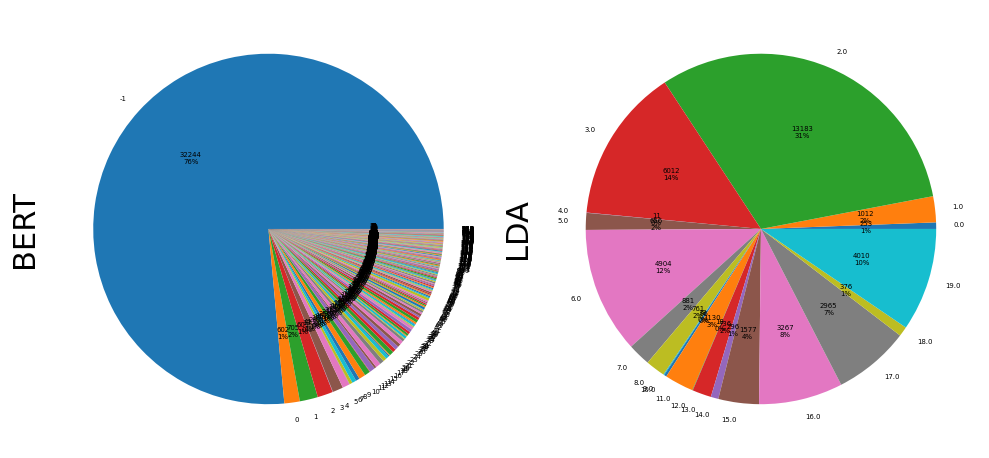

In [71]:
def label_function(val):
    return f'{val / 100 * len(movies):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
movies.groupby('BERT').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax1)
movies.groupby('Topic').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax2)
ax1.set_ylabel('BERT', size=22)
ax2.set_ylabel('LDA', size=22)
plt.tight_layout()
plt.show()

### 1.1.1 With LDA <a id='1.1.1'></a>

### @.1.1 Data preparation <a id='3.1.1'></a>

#### Prepare bi-grams and tri-grams

In [ ]:
tokens = plot_summaries['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [ ]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

### @.1.2 Implementation <a id='3.1.2'></a>

In [ ]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

### @.1.3 Model evaluation <a id='3.1.3'></a>

(by checking how many topics a word exists in)

In [ ]:
topics_ = dict()
for i,topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20):
    topics_[i]=topic

In [ ]:
"""
Counts for each word the number of topics that include it
"""
def count_words(topics_):
    counts = dict()
    for i in topics_:
        for word in topics_[i]:
            if word[0] in counts:
                counts[word[0]]+=1
            else:
                counts[word[0]]=1
    return counts

def takeSecond(elem):
    return elem[1]

In [ ]:
counts = count_words(topics_)
repeated_words = [(k,v) for k,v in counts.items() if v>=4]
repeated_words.sort(reverse=True, key = takeSecond)
repeated_words

### @.1.4 Resulting topics <a id='3.1.4'></a>

In [ ]:
for i in topics_:
    message = "Topic {} : ".format(i) 
    words = str([k for (k,v) in topics_[i]])
    print(message+words)
    print()

### EY.1.5 Topic Visualizations <a id='3.1.5'></a>

Unfortunately, since the plot is interactive when we push the notebook to github it disappears. Hopefully, by milestone 3 we can find a way to host it in a github page. In the meantime, you can find a [screenshot](https://github.com/epfl-ada/ada-2022-project-adaccord/blob/main/topic_visualiation.png) of it in our root repository.

In [ ]:
%matplotlib inline
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### 3.1.6 Assigning topics to movies <a id='3.1.6'></a>

In [ ]:
def most_probable_topic(possible_topics):
    possible_topics.sort(reverse=True, key = takeSecond)
    return possible_topics[0][0]

In [ ]:
chosen_topics = list()
for plot in tqdm(corpus):
    possible_topics = lda_model[plot]
    chosen_topic = most_probable_topic(possible_topics)
    chosen_topics.append(chosen_topic)

chosen_topics = np.array(chosen_topics)

In [ ]:
topics_df = pd.DataFrame(chosen_topics, columns = ["Topic"]) #Rename this to Topic_LDA

topics_df["Index"] = topics_df.index

display(topics_df.head())

In [ ]:
plot_summaries["Index"] = plot_summaries.index

plot_summaries = plot_summaries.merge(topics_df, left_on="Index", right_on="Index").drop(columns=["Index"])

In [ ]:
plot_summaries[["WikiMovieID", "Plot", "Topic"]].head() # Can merge again with movies 

### 1.1.2 With BERT <a id='1.1.2'></a>

[BERTopic](https://maartengr.github.io/BERTopic/index.html) is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. We will use this model to extract once more topics for each movie plots. The reason we repeat this process twice is so we can compare the results between them and by doing so verify them. In the end we will hopefully find a way to merge our results into a more concrete topic prediction.

Labels for the top 10 most common topics.

In [64]:
#bert_topics = model.generate_topic_labels()

bert_topics = pd.read_pickle('predictions/bert_topics.pkl')
bert_topics = pd.DataFrame(bert_topics, columns = ["Bert_Topic"])
bert_topics.head(10)

,Bert_Topic
0,-1_one_film_father
1,0_detective_murder_bank
2,1_conan_tokyo_japan
3,2_ranch_horse_town
4,3_tells_relationship_home
5,4_ship_island_boat
6,5_film_life_movie
7,6_police_prison_drug
8,7_husband_wife_wedding
9,8_madrid_italy_zorro


Visualization of the data set with the BERT topics.

## 1.2 Topics over time<a id='1.2'></a>

In [66]:
movies["year"] = pd.to_datetime(movies.ReleaseDate, errors="coerce").dt.year
movies["five_year_period"] = movies.year//5*5

# A lot of the ReleaseDate are not filled in the initial dataset which leads to NaT (and eventually NaN) values when converting to datetime
movies_with_year = movies[~movies.year.isna()]
print("We could extract the year of the release date for {:.2f}% of the movies".format(len(movies_with_year)/len(movies)*100))

We could extract the year of the release date for 93.80% of the movies


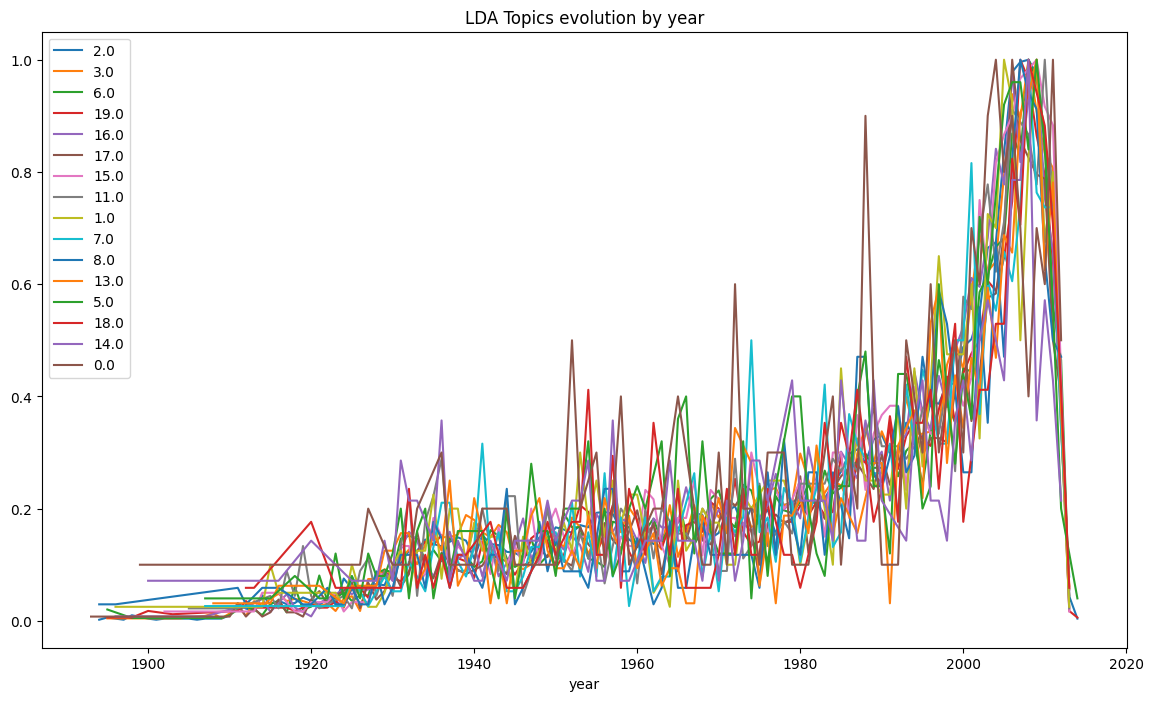

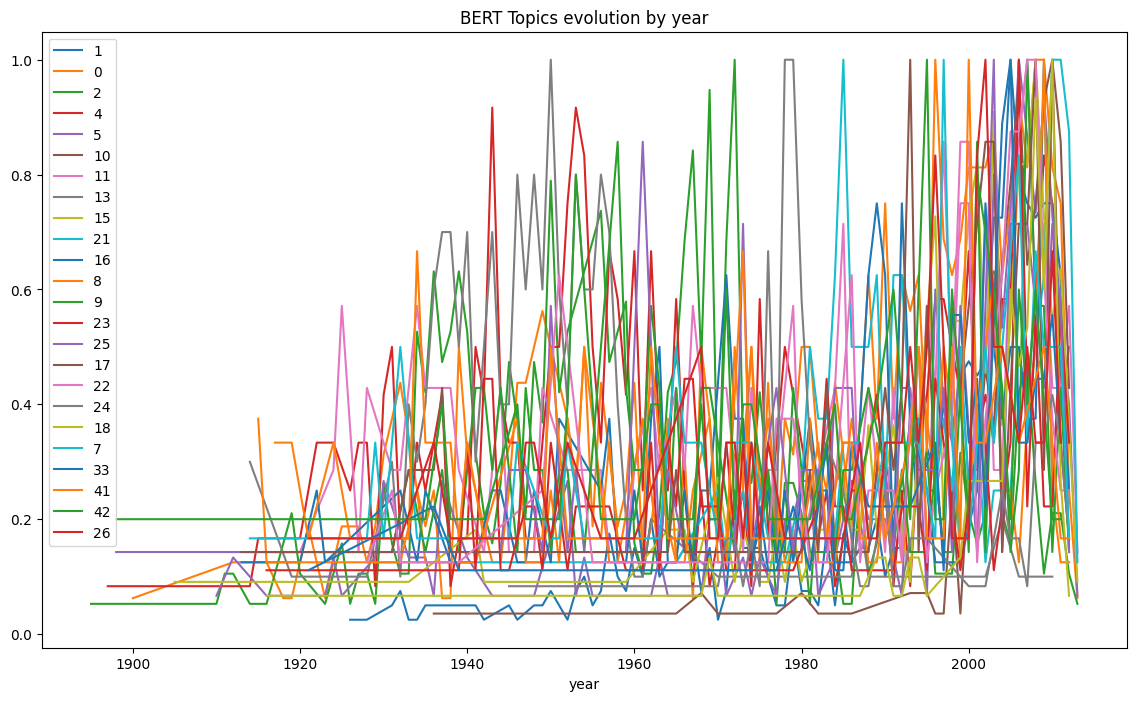

In [67]:
# Unique LDA topics with at least 100 movies assigned
topics_LDA = movies["Topic"].value_counts(dropna=True) 
topics_LDA = topics_LDA[topics_LDA>100].index.tolist()

fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["year"]).size()
    temp = temp/temp.max()   #should we divide by the movies_with_year.groupby(["year"]).size() ???
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by year")
fig = plt.legend()
fig = plt.show()

# Unique BERT topics with at least 100 movies assigned
topics_BERT = movies["BERT"].value_counts(dropna=False) 
topics_BERT = topics_BERT[topics_BERT>100].index.tolist()
## -1 goes to unclassfied movies
topics_BERT.remove(-1)

fig = plt.figure(figsize=(14,8))
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["year"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by year")
fig = plt.legend()
fig = plt.show()

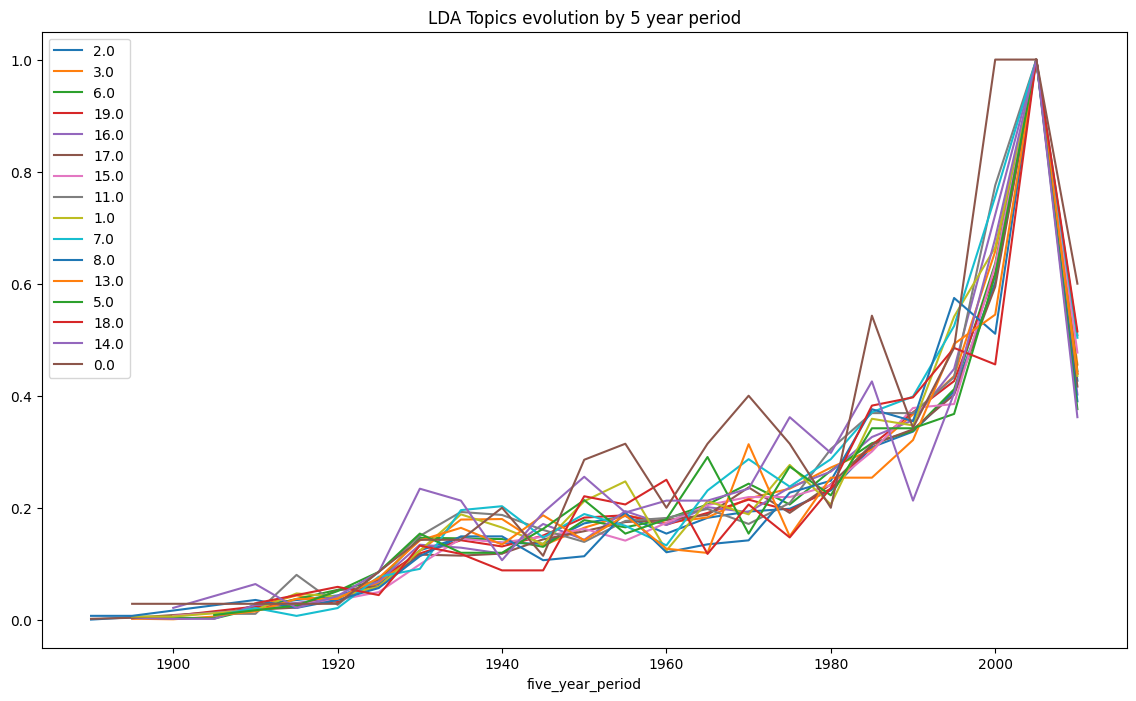

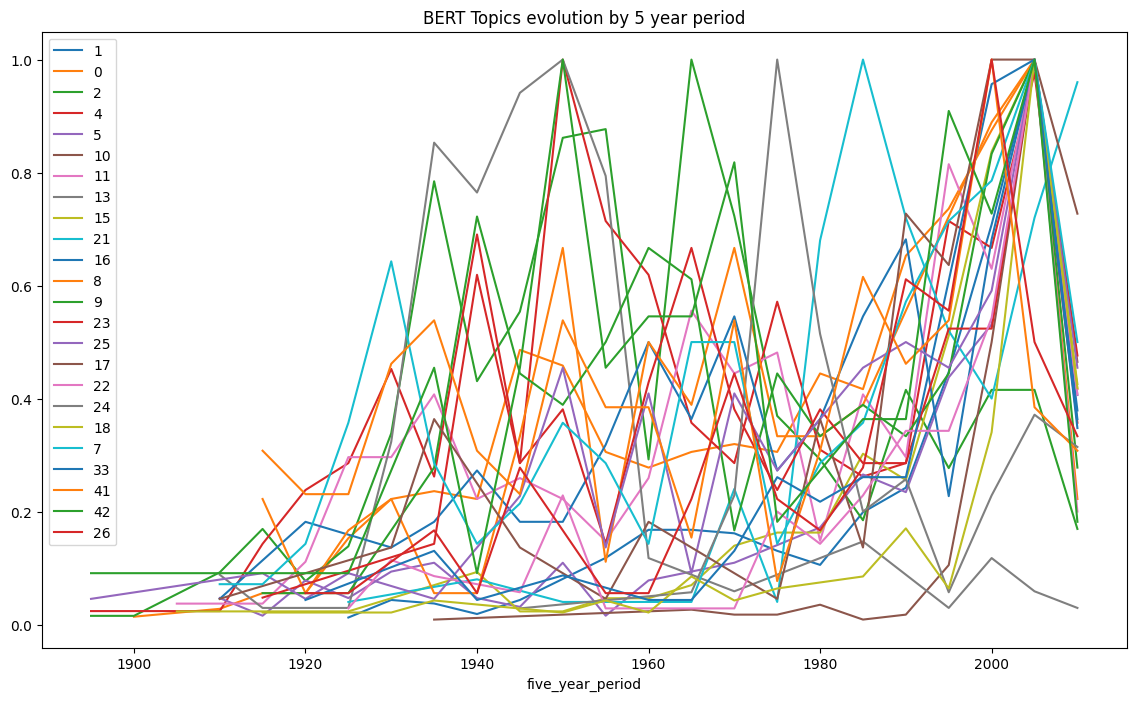

In [46]:
fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

fig = plt.figure(figsize=(14,8)) 
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

Last graph actually could be useful to draw some results. Now it doesn't show (so i'll have to make it show somehow) but if you plot just 1 topic (instead of all of them) you can see that for a few topics there was an interest eirther for a few decades and then it died out or the other way around. Depending on which topics these are (still a number i have to get real tags/names) it could be interesting. 

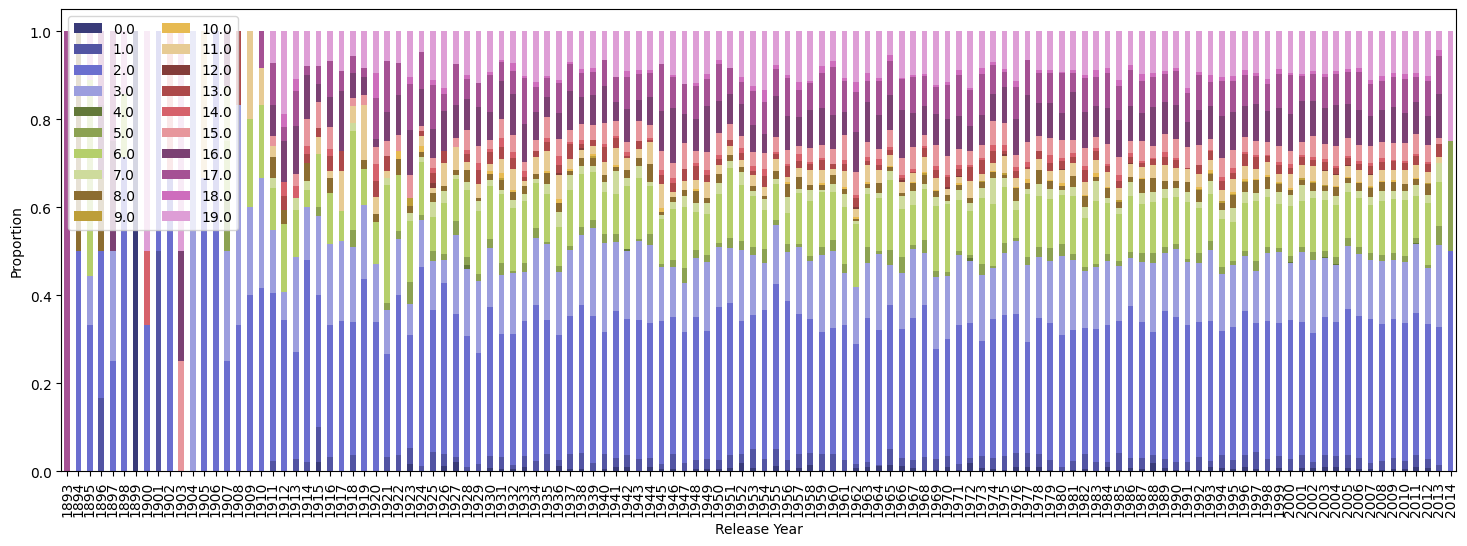

In [10]:
#Evolution over year LDA topics
cross_tab_prop = pd.crosstab(index=movies_with_year["year"].astype(int),
                             columns=movies_with_year["Topic"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(18, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

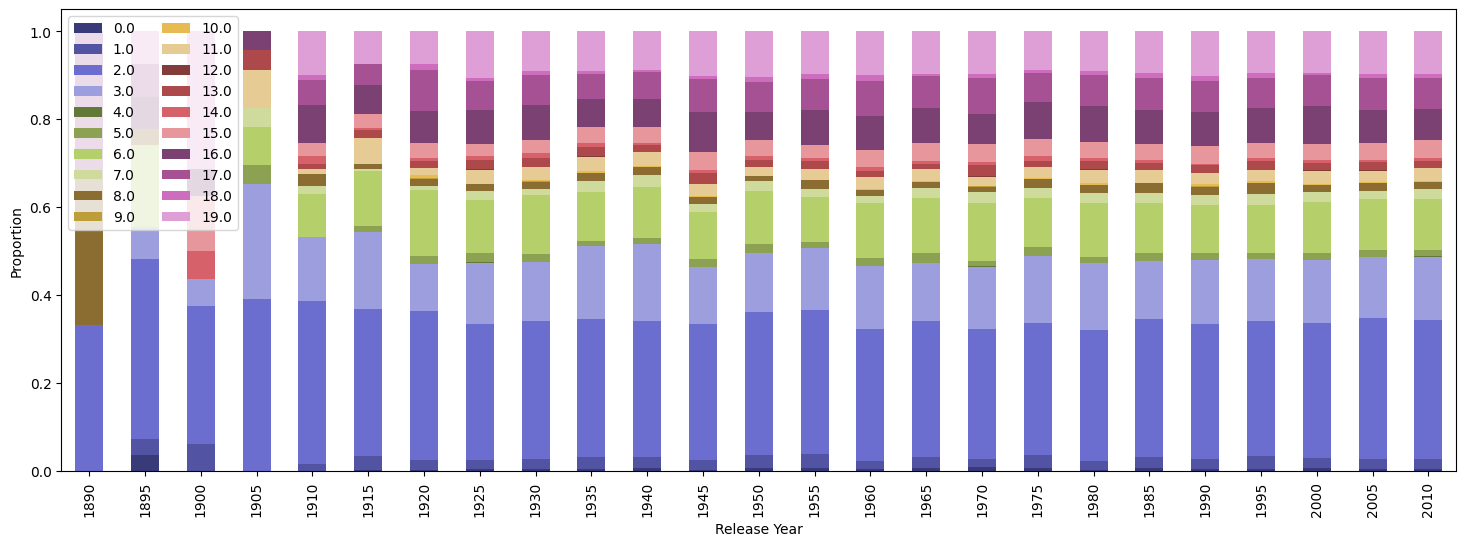

In [11]:
#Evolution over 5years LDA topics
cross_tab_prop = pd.crosstab(index=movies_with_year["five_year_period"].astype(int),
                             columns=movies_with_year["Topic"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(18, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

In [39]:
bert_topics.iloc[1].values

array(['0_detective_murder_bank'], dtype=object)

In [ ]:
BERT_movies_with_year = movies_with_year[movies_with_year['BERT'].isin(topics_BERT)]
#Adding the names of the BERT topics into the data Frame (should we do it earlier)?
BERT_movies_with_year['BERT_names']=bert_topics.iloc[BERT_movies_with_year['BERT'].astype(int)+1].values
BERT_movies_with_year.head() #there is a warning but it does what I want (:

In [ ]:
colors=[[0.22352941, 0.23137255, 0.4745098,  1.        ],
        [0.32156863, 0.32941176, 0.63921569, 1.        ],
        [0.61176471, 0.61960784, 0.87058824, 1.        ],
        [0.38823529, 0.4745098,  0.22352941, 1.        ],
        [0.54901961, 0.63529412, 0.32156863, 1.        ],
        [0.80784314, 0.85882353, 0.61176471, 1.        ],
        [0.54901961, 0.42745098, 0.19215686, 1.        ],
        [0.74117647, 0.61960784, 0.22352941, 1.        ],
        [0.90588235, 0.79607843, 0.58039216, 1.        ],
        [0.51764706, 0.23529412, 0.22352941, 1.        ],
        [0.67843137, 0.28627451, 0.29019608, 1.        ],
        [0.90588235, 0.58823529, 0.61176471, 1.        ],
        [0.48235294, 0.25490196, 0.45098039, 1.        ],
        [0.64705882, 0.31764706, 0.58039216, 1.        ],
        [0.19215686, 0.50980392, 0.74117647, 1.        ],
        [0.41960784, 0.68235294, 0.83921569, 1.        ],
        [0.90196078, 0.33333333, 0.05098039, 1.        ],
        [0.99215686, 0.55294118, 0.23529412, 1.        ],
        [0.19215686, 0.63921569, 0.32941176, 1.        ],
        [0.45490196, 0.76862745, 0.4627451 , 1.        ],
        [0.45882353, 0.41960784, 0.69411765, 1.        ],
        [0.61960784, 0.60392157, 0.78431373, 1.        ],
        [0.38823529, 0.38823529, 0.38823529, 1.        ],
        [0.58823529, 0.58823529, 0.58823529, 1.        ]]
import matplotlib.colors as mcolors
colors_tab20b =  plt.cm.get_cmap('tab20b')
#print(colors_tab20b([0,1,3,4,5,7,8,9,11,12,13,15,16,17]))
colors_tab20c =  plt.cm.get_cmap('tab20c')
#print(colors_tab20c([0,1,4,5,8,9,12,13,16,17]))
#colors = np.vstack((colors_tab20b,colors_tab20c))
#print(colors)
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

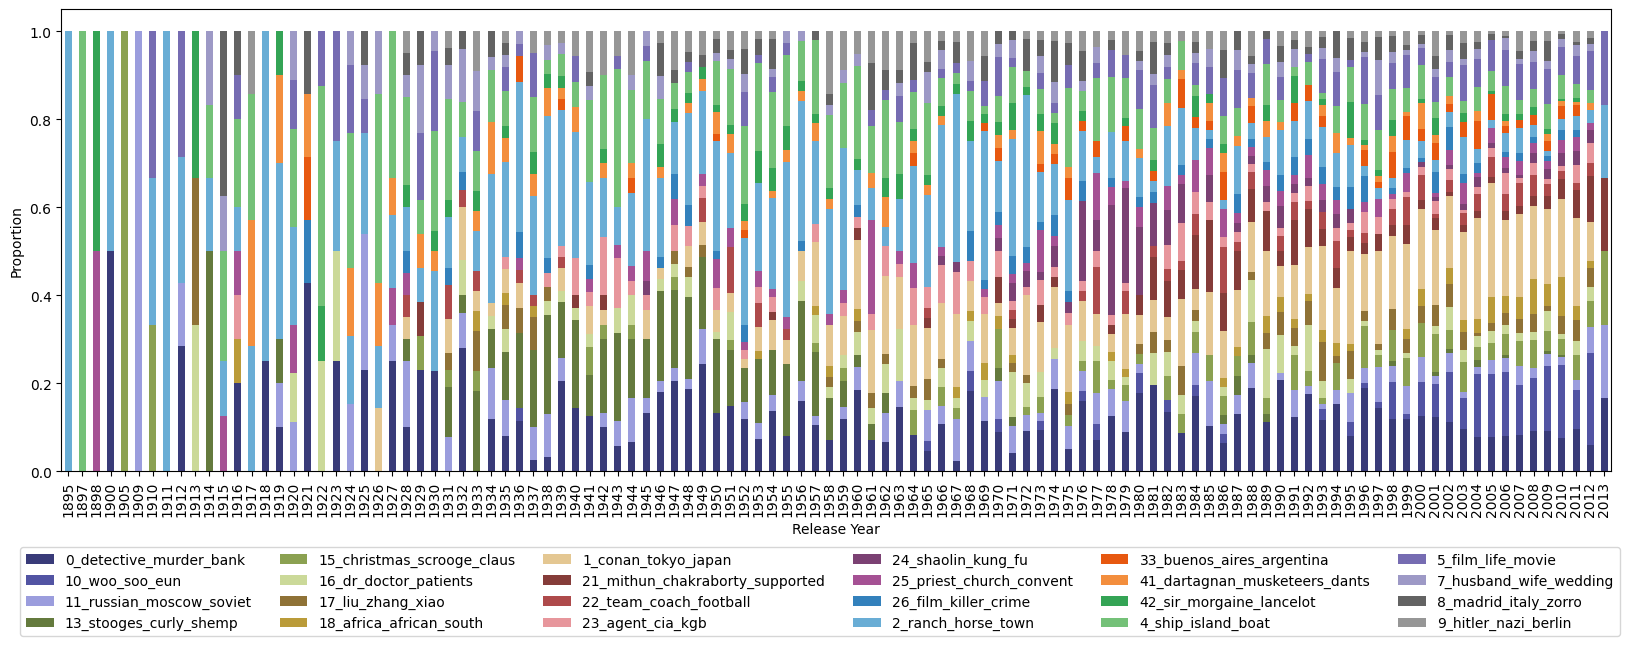

In [51]:
#Evolution over year BERT topics

cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["year"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=mymap, 
                    figsize=(20, 6))

plt.legend(ncol=6,bbox_to_anchor=(1.01, -0.15))
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

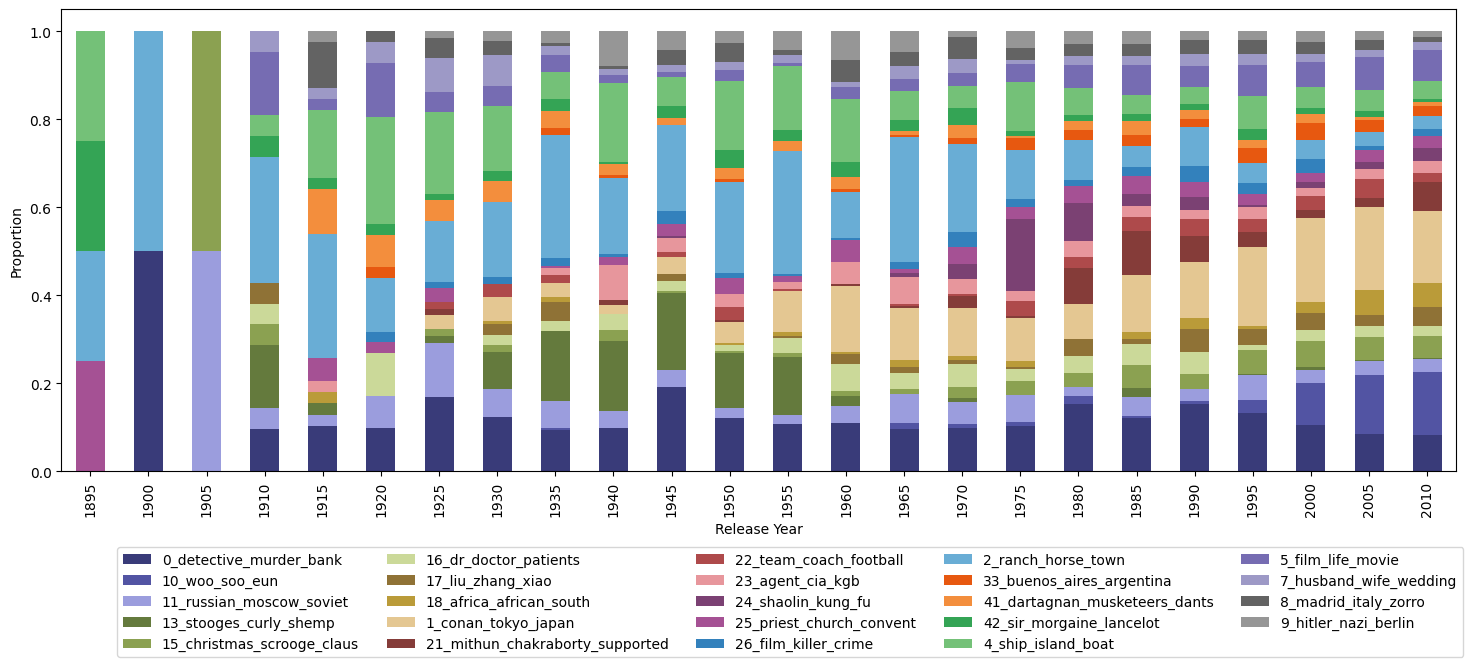

In [53]:
#evolution over 5yers BERT topics
cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["five_year_period"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=mymap, 
                    figsize=(18, 6))

plt.legend(ncol=5,bbox_to_anchor=(1.01, -0.15)) #ncol=1,bbox_to_anchor=(1.01, 1.0))
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

### 1.2.1 With LDA <a id='1.2.1'></a>

### 1.2.2 With BERT <a id='1.2.2'></a>

---

# 2. Targeted Topics <a id='2'></a>

## 2.1 The cathegories <a id='2.1'></a>

### 2.1.1 Description <a id='2.1.1'></a>

### 2.1.2 Distribution <a id='2.1.2'></a>

## 2.2 Categories over time<a id='2.2'></a>

---

# 3. Sentiments <a id='3'></a>

## 3.1 The sentiments <a id='3.1'></a>

### 3.1.1 Plot sentiment analysis <a id='3.1.1'></a>

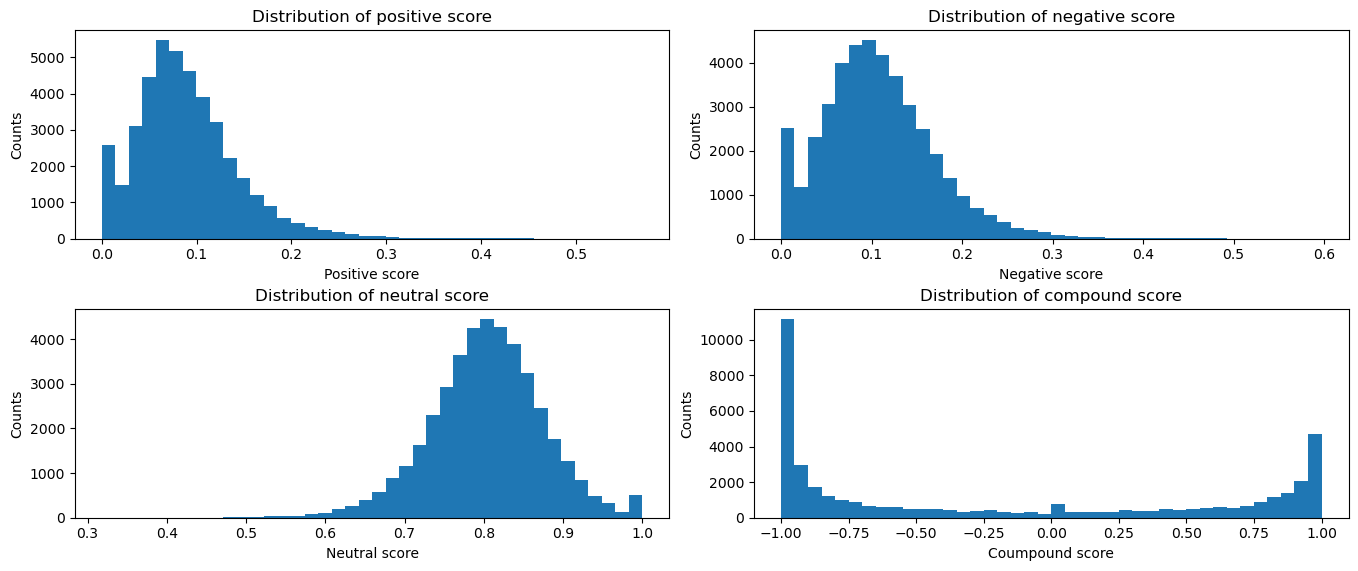

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.positive_score,bins=40)
axs[0,0].set_title('Distribution of positive score')
axs[0,0].set_xlabel('Positive score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.negative_score,bins=40)
axs[0,1].set_title('Distribution of negative score')
axs[0,1].set_xlabel('Negative score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.neutral_score,bins=40)
axs[1,0].set_title('Distribution of neutral score')
axs[1,0].set_xlabel('Neutral score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.compound_score,bins=40)
axs[1,1].set_title('Distribution of compound score')
axs[1,1].set_xlabel('Coumpound score')
axs[1,1].set_ylabel('Counts')

plt.show()

### 3.1.2 Plot multi-sentiments <a id='3.1.2'></a>

Emotional affects measured include the following:

- fear
- anger
- anticipation
- trust
- surprise
- positive
- negative
- sadness
- disgust
- joy

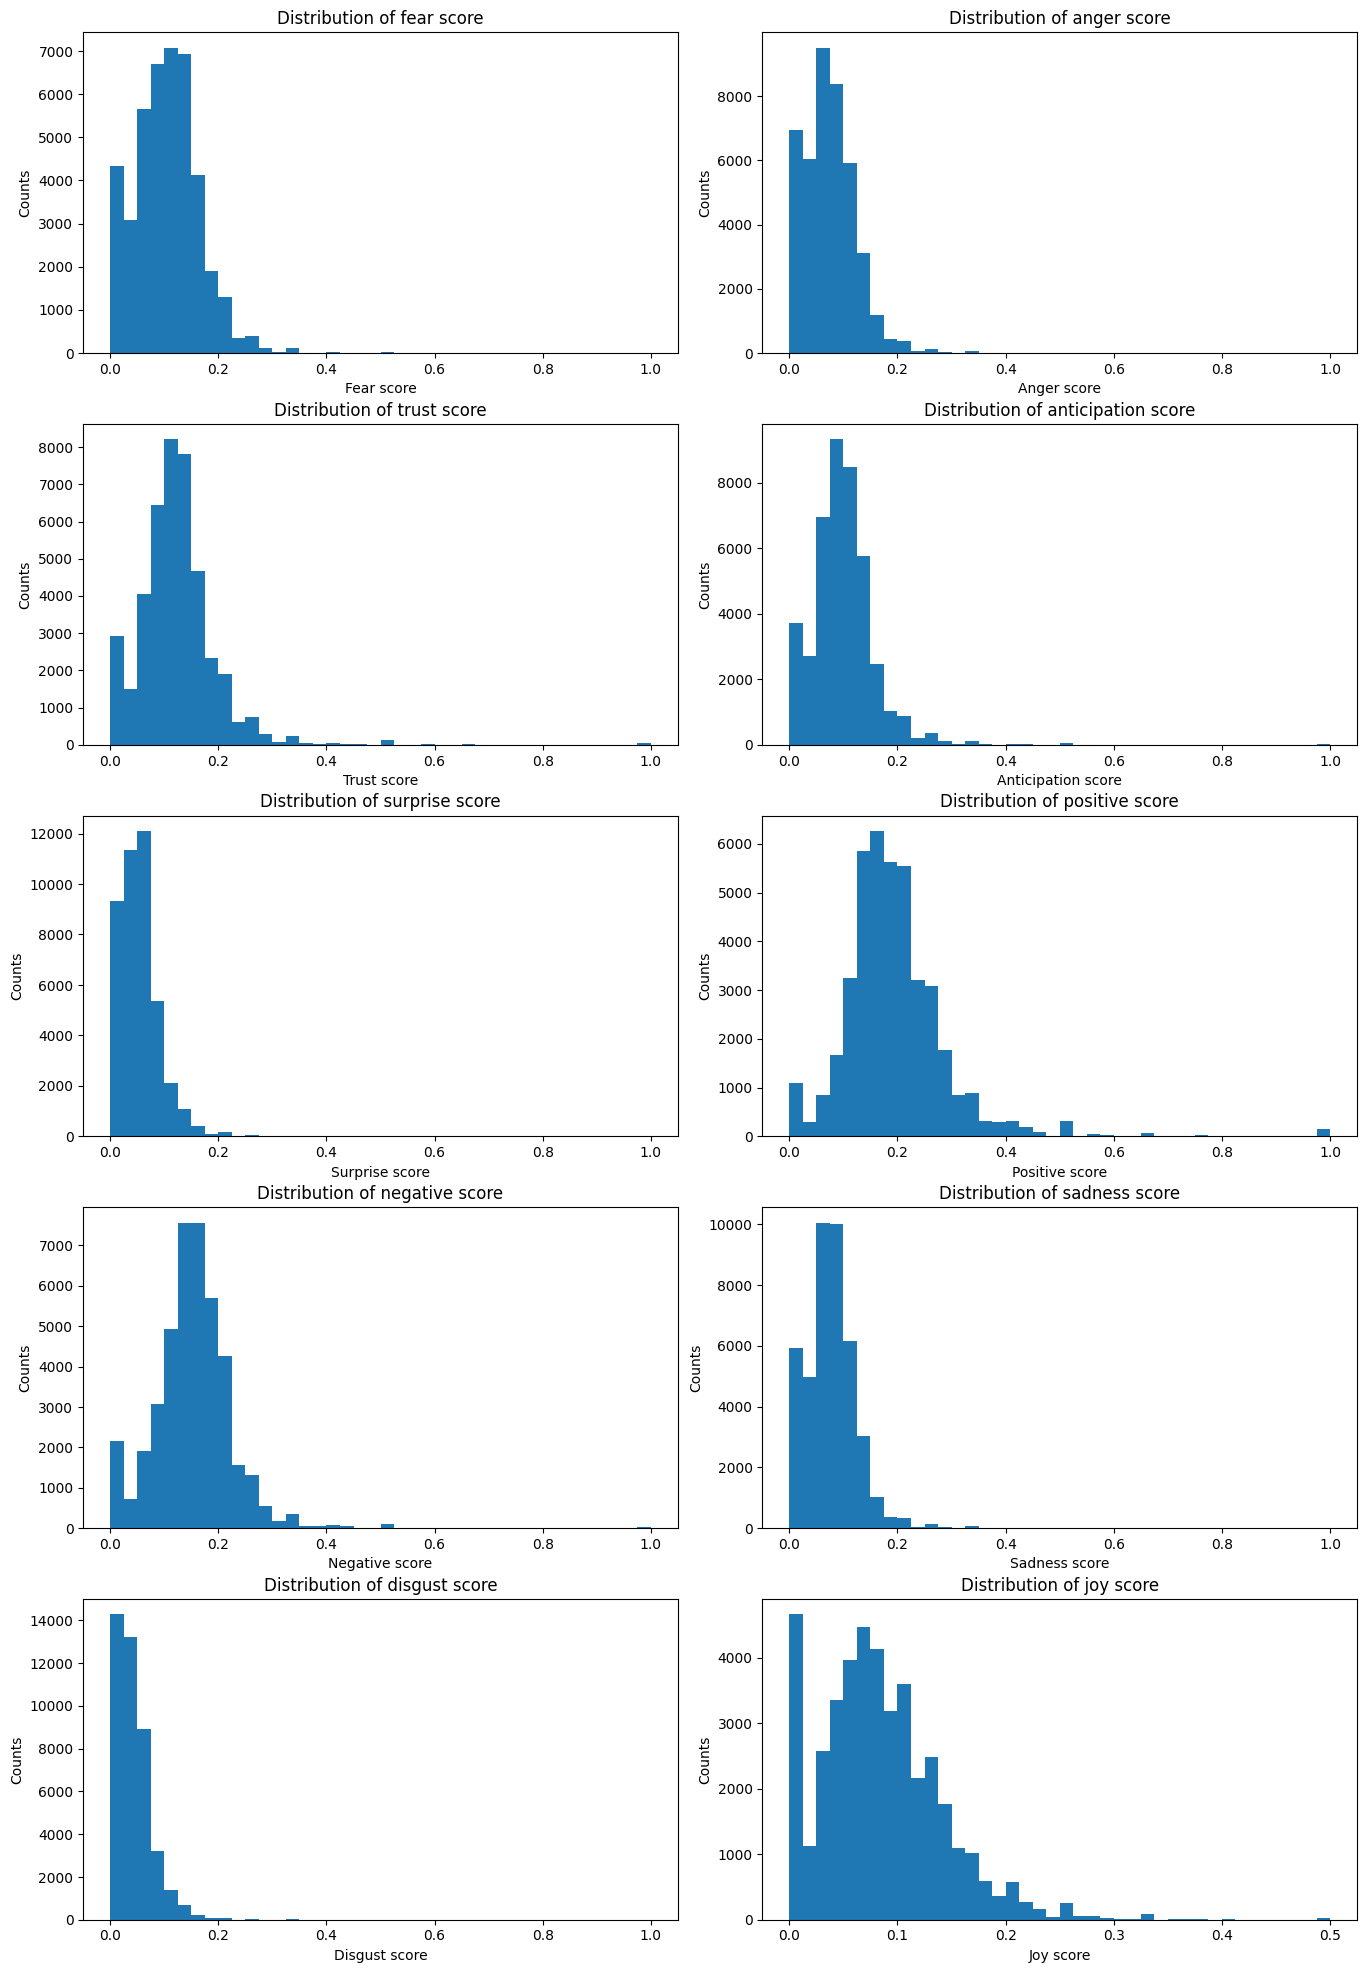

In [56]:
fig, axs = plt.subplots(5, 2, figsize=(14,20))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['fear']),bins=40)
axs[0,0].set_title('Distribution of fear score')
axs[0,0].set_xlabel('Fear score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anger']),bins=40)
axs[0,1].set_title('Distribution of anger score')
axs[0,1].set_xlabel('Anger score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['trust']),bins=40)
axs[1,0].set_title('Distribution of trust score')
axs[1,0].set_xlabel('Trust score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anticipation'] if 'anticipation' in score_dict else 0),bins=40)
axs[1,1].set_title('Distribution of anticipation score')
axs[1,1].set_xlabel('Anticipation score')
axs[1,1].set_ylabel('Counts')

axs[2,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['surprise']),bins=40)
axs[2,0].set_title('Distribution of surprise score')
axs[2,0].set_xlabel('Surprise score')
axs[2,0].set_ylabel('Counts')

axs[2,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['positive']),bins=40)
axs[2,1].set_title('Distribution of positive score')
axs[2,1].set_xlabel('Positive score')
axs[2,1].set_ylabel('Counts')

axs[3,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['negative']),bins=40)
axs[3,0].set_title('Distribution of negative score')
axs[3,0].set_xlabel('Negative score')
axs[3,0].set_ylabel('Counts')

axs[3,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['sadness']),bins=40)
axs[3,1].set_title('Distribution of sadness score')
axs[3,1].set_xlabel('Sadness score')
axs[3,1].set_ylabel('Counts')

axs[4,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['disgust']),bins=40)
axs[4,0].set_title('Distribution of disgust score')
axs[4,0].set_xlabel('Disgust score')
axs[4,0].set_ylabel('Counts')

axs[4,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['joy']),bins=40)
axs[4,1].set_title('Distribution of joy score')
axs[4,1].set_xlabel('Joy score')
axs[4,1].set_ylabel('Counts')


plt.show()

## 2.2 Sentiments over time <a id='2.2'></a>

---

# 4. Combined <a id='4'></a>

## 4.1 Topics and sentiments <a id='4.1'></a>

In [68]:
#Compute the mean for each topic
temp = pd.DataFrame(columns = ['positive', 'negative', 'neutral', 'fear', 'anticip', 'trust', 'surprise','positive_multi',
                               'negative_multi','sadness','disgust','joy','anticipation'], 
                   index = topics_BERT)
for topic in topics_BERT:
    #SA
    temp.at[topic,'positive'] = np.mean(movies[movies['BERT']==topic].positive_score)
    temp.at[topic,'negative'] = np.mean(movies[movies['BERT']==topic].negative_score)
    temp.at[topic,'neutral'] = np.mean(movies[movies['BERT']==topic].neutral_score)
    
    #Multi SA
    temp.at[topic,'fear'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['fear']))
    temp.at[topic,'anticip'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anticip']))
    temp.at[topic,'trust'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['trust']))
    temp.at[topic,'surprise'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['surprise']))
    temp.at[topic,'positive_multi'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['positive']))
    temp.at[topic,'negative_multi'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['negative']))
    temp.at[topic,'sadness'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['sadness']))
    temp.at[topic,'disgust'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['disgust']))
    temp.at[topic,'joy'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['joy']))
    temp.at[topic,'anticipation'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anticipation'] 
                                                                                             if 'anticipation' in score_dict else 0))

In [69]:
#Radar plot of BERT topics for neutral, negative and positive
import plotly.express as px
import plotly.graph_objects as go

theta_ = bert_topics.iloc[np.array(topics_BERT)+1]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.neutral,
        theta=theta_,
        fill='toself',
        name='Neutral sentiment',
        line_color = '#f94436'
))

fig.add_trace(go.Scatterpolar(
        r=temp.negative,
        theta=theta_,
        #mode = 'lines',
        fill='toself',
        name='Negative Sentiment',
        line_color = '#489ede'
))
fig.add_trace(go.Scatterpolar(
        r=temp.positive,
        theta=theta_,
        fill='toself',
        name='Positive sentiment',
        line_color = '#f8d044'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("iframe_figures/radar_chart_trisentiment_BERT.html")

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [70]:
#Radar plot of BERT topics for only negative and positive
#Plotly
import plotly.express as px
import plotly.graph_objects as go

theta_ = bert_topics.iloc[np.array(topics_BERT)+1]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.negative,
        theta=theta_,
        #mode = 'lines',
        fill='toself',
        name='Negative Sentiment',
        line_color = '#489ede'
))
fig.add_trace(go.Scatterpolar(
        r=temp.positive,
        theta=theta_,
        fill='toself',
        name='Positive sentiment',
        line_color = '#f8d044'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("iframe_figures/radar_chart_bisentiment_BERT.html")

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [71]:
#Radar plot of BERT topics for multi SA
import plotly.express as px
import plotly.graph_objects as go

theta_ = bert_topics.iloc[np.array(topics_BERT)+1] 

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.trust,
        theta=theta_,
        fill='toself',
        name='Trust sentiment',
        line_color = '#f8d044'
))
fig.add_trace(go.Scatterpolar(
        r=temp.fear,
        theta=theta_,
        fill='toself',
        name='Fear sentiment',
        line_color = '#f94436'
))
fig.add_trace(go.Scatterpolar(
        r=temp.anticipation,
        theta=theta_,
        fill='toself',
        name='Anticipation sentiment',
        line_color = '#489ede'
))
#fig.add_trace(go.Scatterpolar(
 #       r=temp.positive_multi,
  #      theta=theta_,
   #     fill='toself',
    #    name='Positive sentiment',
     #   line_color = '#f8d044'
#))
#fig.add_trace(go.Scatterpolar(
 #       r=temp.negative_multi,
  #      theta=theta_,
   #     fill='toself',
    #    name='Negative sentiment',
      #  line_color = '#a39d99'
#))
fig.add_trace(go.Scatterpolar(
        r=temp.joy,
        theta=theta_,
        fill='toself',
        name='Joy sentiment',
        line_color = '#de489f'
))
fig.add_trace(go.Scatterpolar(
        r=temp.sadness,
        theta=theta_,
        fill='toself',
        name='Sadness sentiment',
        line_color = '#44c2f8'
))
fig.add_trace(go.Scatterpolar(
        r=temp.surprise,
        theta=theta_,
        fill='toself',
        name='Surprise sentiment',
        line_color = '#f28b0c'
))
fig.add_trace(go.Scatterpolar(
        r=temp.disgust,
        theta=theta_,
        fill='toself',
        name='Disgust sentiment',
        line_color = '#6ab867'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("iframe_figures/radar_chart_multisentiment_BERT.html")

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



---